In [1]:
#importing the useful libraries
import sys
import scipy
import numpy as np
import seaborn as sn
import pandas as pd
pd.options.mode.chained_assignment = None 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from pandas.plotting import scatter_matrix
from pandas import read_csv
import sklearn
from sklearn import datasets
from sklearn import *
from sklearn.datasets import make_classification
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.feature_selection import RFECV
from sklearn.neural_network import MLPRegressor
from sklearn.svm import LinearSVR
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.api import abline_plot
!pip install plotnine
from plotnine import *
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error
# if using a Jupyter notebook, include:
%matplotlib inline

In [36]:
df = pd.read_excel('duration.xlsx')

In [37]:
df.columns = df.columns.str.strip() 
df.dropna()

# Cleaning the data
# Capitalise the word for each categorical variable 

df['Region'] = df['Region'].str.capitalize()
df['Procurement Path'] = df['Procurement Path'].str.capitalize()
df['Building Category'] = df['Building Category'].str.capitalize().str.strip()
df['Project Status'] = df['Project Status'].str.capitalize()
df['Site for development'] = df['Site for development'].str.capitalize()
df['Source of costs'] = df['Source of costs'].str.capitalize()
df.head()

,Region,Procurement Path,GIA Building Total (at start),Building Category,Project Status,Storeys,Inpatient Beds,Operating Theatres,Site for development,Source of costs,Duration
0,London,P22,4335.0,Mental health,Built,2.0,74.0,NaN,Hospital grounds,Trust cost plan,NaN
1,London,P21,22945.0,District (medium),Built,5.0,101.0,8.0,Hospital grounds,Trust cost plan,1160.0
2,South east,P21,9200.0,Emergency centre,Built,3.0,NaN,NaN,Hospital grounds,Trust cost plan,690.0
3,South east,P21,9109.0,District (medium),Under construction,4.0,48.0,6.0,Greenfield,Trust cost plan,828.0
4,North east,P22,10536.0,Emergency centre,Built,1.0,NaN,NaN,Hospital grounds,Trust cost plan,797.0


In [38]:
# Drop the Absolute_Duration_day that is smaller than 100 days
df = df[(df['Duration'] >= 100) | (df['Duration'].isnull())]

In [39]:
# Identify numerical columns
numerical_columns = df.select_dtypes(include=[np.number]).columns

# Log-transform numerical columns
df[numerical_columns] = np.log1p(df[numerical_columns])

In [40]:
# one-hot encoding to make categorical data numerical
# drop_first=true is used to break colliarity, as otherwise the linear model will be off
dfn = pd.get_dummies(df,drop_first=True)
dfn.shape

(54, 42)

In [41]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num_corr = df_num.corr()
df_num_corr

,GIA Building Total (at start),Storeys,Inpatient Beds,Operating Theatres,Duration
GIA Building Total (at start),1.000000,0.679455,0.693222,0.710292,0.667420
Storeys,0.679455,1.000000,0.290006,0.351470,0.622578
Inpatient Beds,0.693222,0.290006,1.000000,0.609269,0.412173
Operating Theatres,0.710292,0.351470,0.609269,1.000000,0.517739
Duration,0.667420,0.622578,0.412173,0.517739,1.000000


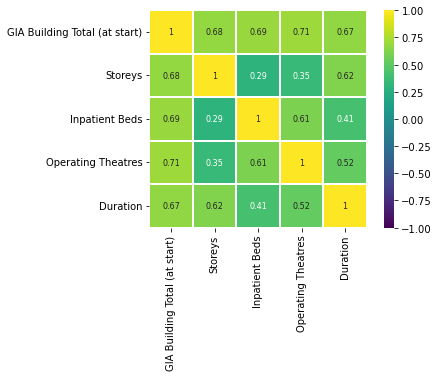

In [42]:
sn.heatmap(df_num_corr, 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8}, square=True);

In [43]:
dfn = dfn.drop(columns=['Inpatient Beds'])

In [44]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num_corr = df_num.corr()
df_num_corr

,GIA Building Total (at start),Storeys,Inpatient Beds,Operating Theatres,Duration
GIA Building Total (at start),1.000000,0.679455,0.693222,0.710292,0.667420
Storeys,0.679455,1.000000,0.290006,0.351470,0.622578
Inpatient Beds,0.693222,0.290006,1.000000,0.609269,0.412173
Operating Theatres,0.710292,0.351470,0.609269,1.000000,0.517739
Duration,0.667420,0.622578,0.412173,0.517739,1.000000


In [45]:
# Replacing infinite with nan
dfn.replace([np.inf, -np.inf], np.nan, inplace=True)

In [46]:
# imputate by using median method
dfn['Duration'] = dfn['Duration'].fillna(dfn['Duration'].median())
dfn['Storeys'] = dfn['Storeys'].fillna(dfn['Storeys'].median())
dfn['GIA Building Total (at start)'] = dfn['GIA Building Total (at start)'].fillna(dfn['GIA Building Total (at start)'].median())
dfn['Operating Theatres'] = dfn['Operating Theatres'].fillna(dfn['Operating Theatres'].median())

In [47]:
#splitting data into x and y
X = dfn.drop('Duration', axis=1)
y= dfn['Duration']

In [48]:
# rfe works by fitting the ml model, ranking features by importance, discarding the least important fetaure, re-fitting the model
# and then recursively doing this until the selected number of features is left

# implementing rfe using a linear model selecting top 10 features

# create pipeline
rfe = RFE(estimator=linear_model.LinearRegression(fit_intercept=False), n_features_to_select=10)
model = linear_model.LinearRegression(fit_intercept=False)
pipeline = Pipeline(steps=[('s',rfe),('m',model)])

# evaluate model using cross validation
# cv splits the data into 10 groups, then takes out one group to be the test data and evaluates it 
# this is repeated so each group is evaluated as the test data, and then the results of all are averaged
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')

# report performance
print('MAE: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

MAE: -0.646 (0.775)


In [49]:
def get_models():
	models = dict()
	# linear regresssion
	rfe = RFE(estimator=linear_model.LinearRegression(fit_intercept=False), n_features_to_select=25)
	model = linear_model.LinearRegression(fit_intercept=False)
	models['LR'] = Pipeline(steps=[('s',rfe),('m',model)])
	 #bayesian ridge regression
	rfe = RFE(estimator=linear_model.BayesianRidge(), n_features_to_select=10)
	model = linear_model.BayesianRidge()
	models['BRR'] = Pipeline(steps=[('s',rfe),('m',model)])
	# cart
	rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=10)
	model = DecisionTreeRegressor()
	models['CART'] = Pipeline(steps=[('s',rfe),('m',model)])
	# random forest
	rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=10)
	model = RandomForestRegressor()
	models['RF'] = Pipeline(steps=[('s',rfe),('m',model)])
	# gradient boosting machine
	rfe = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=10)
	model = GradientBoostingRegressor()
	models['GBM'] = Pipeline(steps=[('s',rfe),('m',model)])
	# support vector machine
	rfe = RFE(estimator=LinearSVR(random_state=0, tol=1e-5), n_features_to_select=10)
	model = LinearSVR(random_state=0, tol=1e-5)
	models['SVM'] = Pipeline(steps=[('s',rfe),('m',model)])
	return models

 
# evaluate each model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
	return scores
 
    
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>LR -0.437 (0.215)
>BRR -0.283 (0.093)
>CART -0.340 (0.124)
>RF -0.279 (0.085)
>GBM -0.285 (0.079)
>SVM -0.368 (0.124)


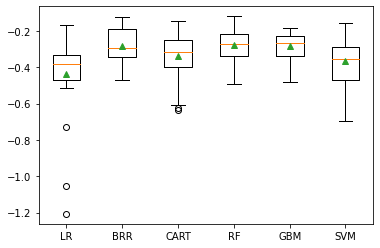

In [50]:
# plot model performance for comparison
#orange line is median, green triangle is mean, box shows variation of scores
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

## RF

In [53]:
# Split the data into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 0)

# print the info about the split data
print('Training Features Shape:', train_X.shape)
print('Training Labels Shape:', train_y.shape)
print('Testing Features Shape:', test_X.shape)
print('Testing Labels Shape:', test_y.shape)

Training Features Shape: (40, 40)
Training Labels Shape: (40,)
Testing Features Shape: (14, 40)
Testing Labels Shape: (14,)


In [54]:
## Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 0)
# Train the model on training data
rf.fit(train_X, train_y);

In [55]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_X)
# Calculate the absolute errors
errors = abs(predictions - test_y)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.3 degrees.


In [56]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_y)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 95.64 %.


In [57]:
# Variable Importances
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:56} Importance: {}'.format(*pair)) for pair in feature_importances];

NameError: name 'feature_list' is not defined